In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataset import build_dataloaders
from bilstm import BiLSTMAttentionClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttentionClassifier(
    pc_vocab=9,
    acc_vocab=10,
    oct_vocab=7,
    dur_vocab=46,
    meas_vocab=4,
    emb_dim=128,
    lstm_hidden=64,
    num_classes=12,
    dropout=0.3
)
model.to(device)
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print("Loaded best model from epoch:", checkpoint["epoch"])

_, _, _, test_loader = build_dataloaders(
    "vocab.pkl", "dataset.pkl", batch_size=8)

Loaded best model from epoch: 17


In [21]:
@torch.no_grad()
def get_predictions(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []
    all_f_names = []
    all_attn_weights = []
    all_true_lengths = []
    all_pcs = []
    all_accs = []
    all_meas = []

    for batch in dataloader:
        f_names = batch["f_names"]
        lengths = batch["lengths"]
        batch["accs"]
        batch["meas"]
        batch = {k: v.to(device) for k, v in batch.items() if k != "f_names"}
        logits, attn_weights = model(batch)
        labels = batch["labels"]
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_f_names.append(f_names)
        all_attn_weights.extend(attn_weights.cpu().numpy())
        all_true_lengths.append(lengths.cpu().numpy())
        all_pcs.extend(batch["pcs"].cpu().numpy())
        all_accs.extend(batch["accs"].cpu().numpy())
        all_meas.extend(batch["meas"].cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_f_names = np.concatenate(all_f_names)
    all_true_lengths = np.concatenate(all_true_lengths)

    return (
        all_labels,
        all_preds,
        all_f_names,
        all_attn_weights,
        all_true_lengths,
        all_pcs,
        all_accs,
        all_meas
    )

In [24]:
(
    all_labels,
    all_preds,
    all_f_names,
    all_attn_weights,
    all_true_lengths,
    all_pcs,
    all_accs,
    all_meas
) = get_predictions(model, test_loader, device)

In [26]:
print(
    all_labels.shape,
    all_preds.shape,
    all_f_names.shape,
    len(all_attn_weights),
    all_true_lengths.shape,
    len(all_pcs),
    len(all_accs),
    len(all_meas)
)

(175,) (175,) (175,) 175 (175,) 175 175 175


In [29]:
makam_vocab = {"hicaz": 0,
               "nihavent": 1,
               "ussak": 2,
               "rast": 3,
               "huzzam": 4,
               "segah": 5,
               "huseyni": 6,
               "mahur": 7,
               "hicazkar": 8,
               "kurdilihicazkar": 9,
               "muhayyer": 10,
               "saba": 11}
makam_names = [k for k in makam_vocab]

pc_vocab = {
    "PAD": 0, "Rest": 1,
    "G": 2, "A": 3, "B": 4, "C": 5, "D": 6, "E": 7, "F": 8
}
pc_vocab_inv = {v: k for k, v in pc_vocab.items()}

acc_vocab = {"PAD": 0, "": 1,
             "#1": 2, "#2": 3, "#3": 4, "#4": 5, "#5": 6, "#6": 7, "#7": 8, "#8": 9}
acc_vocab_inv = {v: k for k, v in acc_vocab.items()}

In [30]:
def evaluate_classification(y_true, y_pred, makam_names):
    results = {}

    # Overall accuracy
    results["accuracy"] = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 per class
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        average=None
    )

    # Macro & weighted
    results["macro_f1"] = np.mean(f1)
    results["weighted_f1"] = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="weighted"
    )[2]

    # Confusion matrix
    results["confusion_matrix"] = confusion_matrix(y_true, y_pred)

    print(classification_report(
        y_true,
        y_pred,
        target_names=makam_names,
        digits=4
    ))
    return results

In [31]:
results = evaluate_classification(all_labels, all_preds, makam_names)

                 precision    recall  f1-score   support

          hicaz     1.0000    1.0000    1.0000        27
       nihavent     1.0000    1.0000    1.0000        18
          ussak     0.7500    0.8571    0.8000        14
           rast     0.9231    1.0000    0.9600        12
         huzzam     1.0000    1.0000    1.0000        17
          segah     1.0000    1.0000    1.0000        22
        huseyni     0.6000    0.5455    0.5714        11
          mahur     1.0000    0.8947    0.9444        19
       hicazkar     1.0000    1.0000    1.0000        11
kurdilihicazkar     1.0000    1.0000    1.0000         6
       muhayyer     0.8889    0.8889    0.8889         9
           saba     1.0000    1.0000    1.0000         9

       accuracy                         0.9429       175
      macro avg     0.9302    0.9322    0.9304       175
   weighted avg     0.9439    0.9429    0.9426       175



In [32]:
results["confusion_matrix"]

array([[27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 22,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  6,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  1, 17,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9]])

In [33]:
def plot_confusion_matrix(
    cm,
    class_names,
    title="Normalized Confusion Matrix"
):
    # Normalize row-wise
    cm = cm.astype(float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(7, 6))
    sns.set_theme(style="white", font="Times")

    ax = sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        annot_kws={"size": 10}
    )

    ax.set_xlabel("Predicted Makam", fontsize=12)
    ax.set_ylabel("True Makam", fontsize=12)
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_title(title, fontsize=12, pad=12)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig("cm.pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()

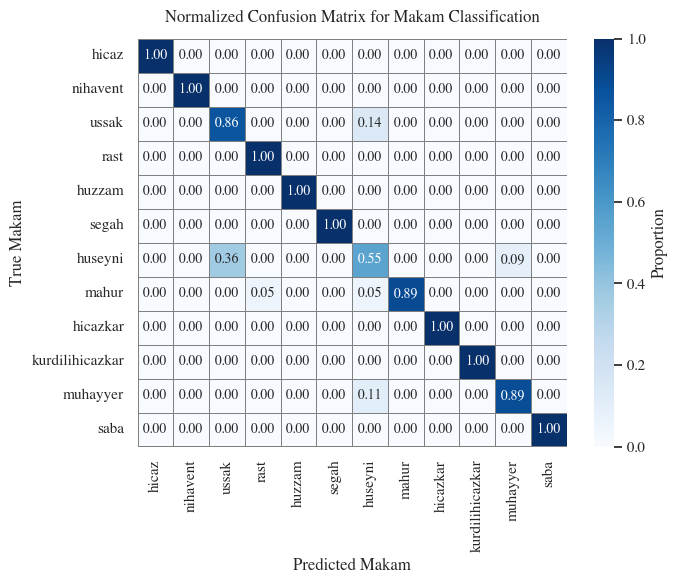

In [34]:
plot_confusion_matrix(
    results["confusion_matrix"],
    makam_names,
    title="Normalized Confusion Matrix for Makam Classification"
)

In [35]:
def plot_attention_over_time(attn, title="Attention over Notes"):
    plt.figure(figsize=(12, 3))
    plt.plot(attn, linewidth=2)
    plt.xlabel("Note Index")
    plt.ylabel("Attention Weight")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [36]:
def plot_attention_with_pitch(attn, pcs, pc_vocab_inv):
    pitches = [pc_vocab_inv[p] for p in pcs]

    plt.figure(figsize=(24, 3))
    plt.bar(range(len(attn)), attn)
    plt.xticks(
        range(len(pitches)),
        pitches,
        rotation=90,
        fontsize=8
    )
    plt.xlabel("Note Index")
    plt.ylabel("Attention Weight")
    plt.title("Attention Aligned with Pitch Classes")
    plt.tight_layout()
    plt.savefig("pitch_attn.pdf")
    plt.show()

In [37]:
def plot_attention_with_measures(attn, meas):
    plt.figure(figsize=(24, 3))
    plt.plot(attn, linewidth=2)

    for i, m in enumerate(meas):
        if m == 3:  # measure end {'PAD': 0, 'start': 1, 'middle': 2, 'end': 3}
            plt.axvline(i, color="red", alpha=0.2)

    plt.xlabel("Note Index")
    plt.ylabel("Attention Weight")
    plt.title("Attention with Measure Boundaries")
    plt.tight_layout()
    plt.show()

In [38]:
def combine_pitch_pc_acc(pc_idx, acc_idx, pc_vocab_inv, acc_vocab_inv):
    pc = pc_vocab_inv.get(pc_idx, "UNK")
    acc_name = acc_vocab_inv.get(acc_idx, "natural")

    if pc == "PAD":
        return "PAD"
    if pc == "Rest":
        return "Rest"

    return f"{pc}{acc_name}"

In [39]:
def plot_attention_with_combined_pitch(
    attn,
    pcs,
    accs,
    pc_vocab_inv,
    acc_vocab_inv
):
    pitch_labels = [
        combine_pitch_pc_acc(p, a, pc_vocab_inv, acc_vocab_inv)
        for p, a in zip(pcs, accs)
    ]

    plt.figure(figsize=(24, 3))
    plt.bar(range(len(attn)), attn)
    plt.xticks(
        range(len(pitch_labels)),
        pitch_labels,
        rotation=90,
        fontsize=8
    )
    plt.xlabel("Note Index")
    plt.ylabel("Attention Weight")
    plt.title("Attention Aligned with Combined Pitch Classes")
    plt.tight_layout()
    plt.show()

In [40]:
all_true_lengths[:10]

array([862, 570, 435, 434, 422, 280, 259, 250, 854, 467])

In [45]:
i = 6  # index of the piece in the test set

# all_labels, all_preds, all_f_names, all_attn_weights, all_true_lengths

true_len = all_true_lengths[i]

attn_piece = all_attn_weights[i][:true_len]
pcs_piece = all_pcs[i][:true_len]
accs_piece = all_accs[i][:true_len]
meas_piece = all_meas[i][:true_len]
print(makam_names[all_labels[i]], all_f_names[i])
attn_piece.shape == pcs_piece.shape == (true_len,)

hicaz hicaz--turku--sofyan--suda_balik--kirsehir.txt


True

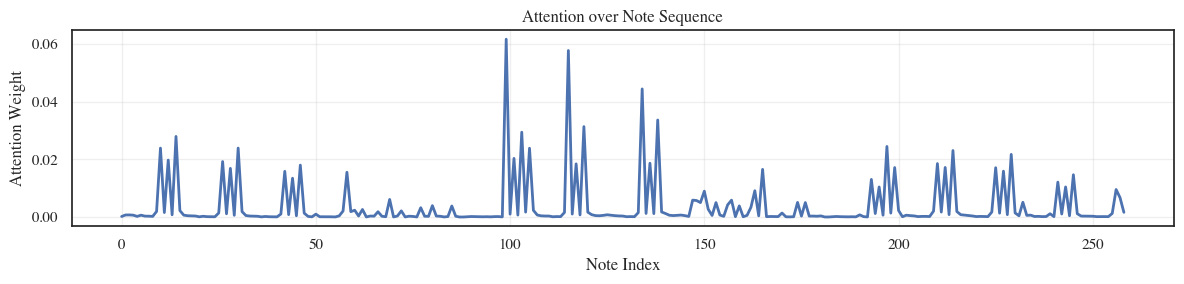

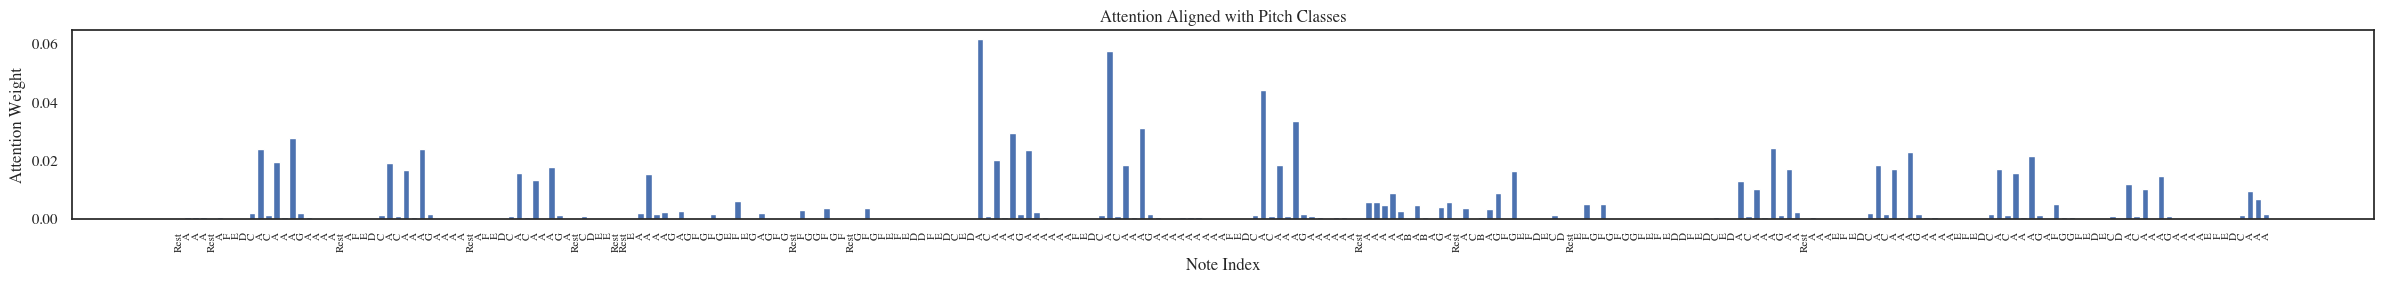

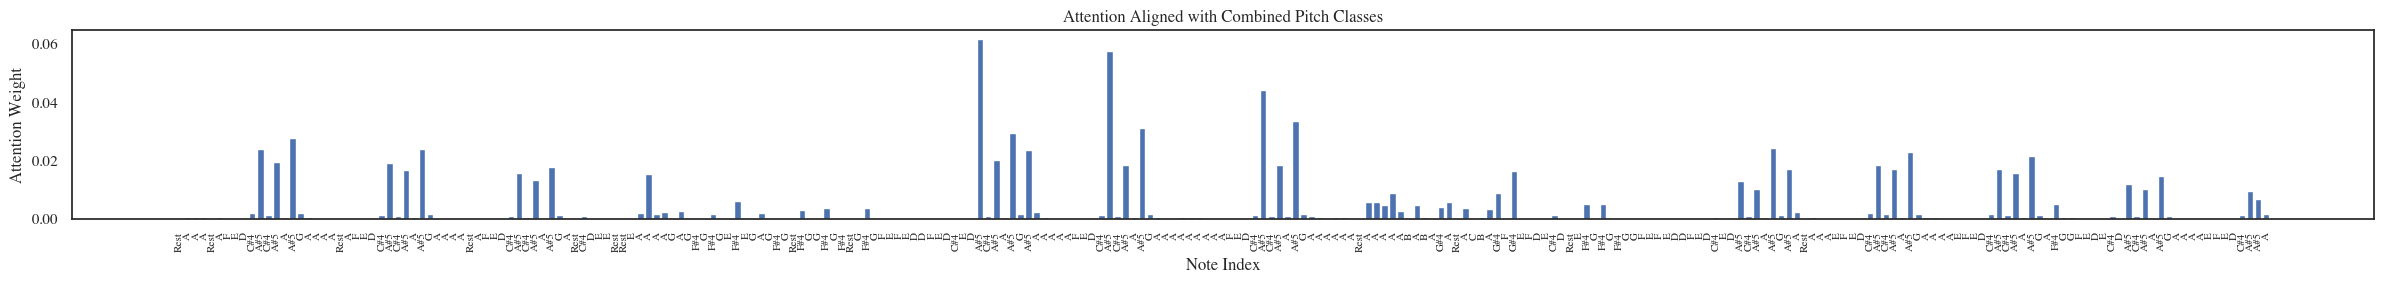

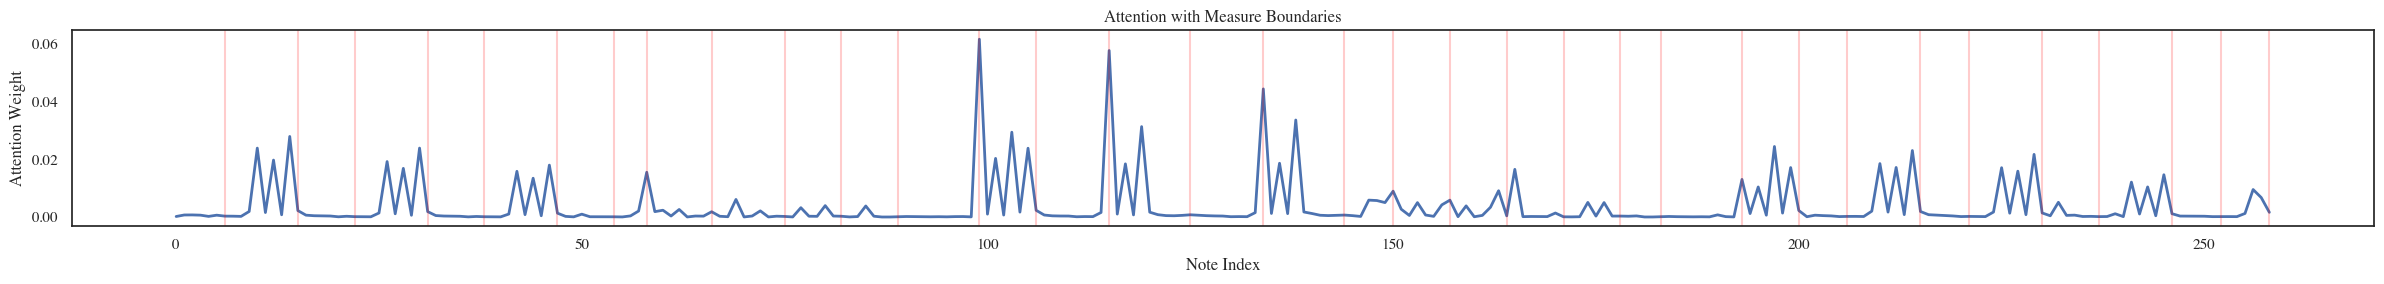

In [46]:
plot_attention_over_time(
    attn_piece,
    title="Attention over Note Sequence"
)
plot_attention_with_pitch(
    attn_piece,
    pcs_piece,
    pc_vocab_inv
)
plot_attention_with_combined_pitch(
    attn_piece,
    pcs_piece,
    accs_piece,
    pc_vocab_inv,
    acc_vocab_inv
)
plot_attention_with_measures(attn_piece, meas_piece)